In [23]:
# import necessary libraries
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM) 

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import warnings
warnings.filterwarnings("ignore")

Question 1

In [4]:
# load the Auto dataset
Auto = load_data('Auto').dropna()
mpg = Auto['mpg']
hp = Auto['horsepower']

In [8]:
models = [MS([poly('horsepower', degree=d)]) 
          for d in range(1, 6)]
Xs = [model.fit_transform(Auto) for model in models] #fit the models and get the design matrices
anova_lm(*[sm.OLS(mpg, X_).fit()
           for X_ in Xs]) #perform ANOVA to compare the models


,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,9385.915872,0.0,NaN,NaN,NaN
1,389.0,7442.029412,1.0,1943.886460,103.876722,8.878263e-22
2,388.0,7426.436007,1.0,15.593405,0.833275,3.618941e-01
3,387.0,7399.522632,1.0,26.913375,1.438187,2.311666e-01
4,386.0,7223.371686,1.0,176.150946,9.413092,2.306428e-03


In [10]:
# Let's interpret the ANOVA results
print("ANOVA Results Interpretation:")
print("============================")

print("Specific comparison requested:")
print("Degree 4 (quartic) vs Degree 3 (cubic):")
print(f"F-statistic: {1.44:.6f}")
print(f"p-value: {0.231:.6f}")
print()
print("Statistical Justification (α = 0.05):")
print("- Degree 2 vs Degree 1: Significant (p < 0.001)")
print("- Degree 3 vs Degree 2: Not significant (p = 0.362)")
print("- Degree 4 vs Degree 3: Not significant (p = 0.231)")  
print("- Degree 5 vs Degree 4: Significant (p = 0.002)")


ANOVA Results Interpretation:
Specific comparison requested:
Degree 4 (quartic) vs Degree 3 (cubic):
F-statistic: 1.440000
p-value: 0.231000

Statistical Justification (α = 0.05):
- Degree 2 vs Degree 1: Significant (p < 0.001)
- Degree 3 vs Degree 2: Not significant (p = 0.362)
- Degree 4 vs Degree 3: Not significant (p = 0.231)
- Degree 5 vs Degree 4: Significant (p = 0.002)


The degree 2 (quadratic) model is the statistically justified polynomial degree based on the ANOVA results. The comparison between degree 2 vs degree 1 shows a highly significant improvement (F = 103.88, p < 0.001)
However, the comparison between degree 3 vs degree 2 is not significant (F = 0.83, p = 0.362) and the comparison between degree 4 vs degree 3 is not significant (F = 1.44, p = 0.231). Adding higher-order terms (cubic or quartic) does not significantly improve the model fit and would constitute overfitting.

Question 2

In [11]:
#load Boston dataset
Boston = load_data('Boston').dropna()
medv = Boston['medv']
lstat = Boston['lstat']

In [12]:
bs_ = BSpline(internal_knots=[10,20,30], intercept=True).fit(lstat)
bs_lstat = bs_.transform(lstat)

In [14]:
M = sm.OLS(medv, bs_lstat).fit()
summarize(M) 

,coef,std err,t,P>|t|
"BSpline(intercept=True, internal_knots=[10, 20, 30], lower_bound=np.float64(1.73), upper_bound=np.float64(37.97))[0]",51.7319,1.819,28.444,0.000
"BSpline(intercept=True, internal_knots=[10, 20, 30], lower_bound=np.float64(1.73), upper_bound=np.float64(37.97))[1]",27.0811,1.287,21.034,0.000
"BSpline(intercept=True, internal_knots=[10, 20, 30], lower_bound=np.float64(1.73), upper_bound=np.float64(37.97))[2]",22.8550,1.371,16.673,0.000
"BSpline(intercept=True, internal_knots=[10, 20, 30], lower_bound=np.float64(1.73), upper_bound=np.float64(37.97))[3]",13.5147,1.532,8.820,0.000
"BSpline(intercept=True, internal_knots=[10, 20, 30], lower_bound=np.float64(1.73), upper_bound=np.float64(37.97))[4]",10.4277,2.491,4.185,0.000
"BSpline(intercept=True, internal_knots=[10, 20, 30], lower_bound=np.float64(1.73), upper_bound=np.float64(37.97))[5]",12.3460,4.024,3.068,0.002
"BSpline(intercept=True, internal_knots=[10, 20, 30], lower_bound=np.float64(1.73), upper_bound=np.float64(37.97))[6]",11.7912,4.411,2.673,0.008


In [17]:
# Get R-squared and number of basis functions
print("B-spline Model Results:")
print("======================")
print(f"R-squared: {M.rsquared:.6f}")
print(f"Adjusted R-squared: {M.rsquared_adj:.6f}")
print()
print("B-spline Transformation Details:")
print(f"Shape of B-spline matrix: {bs_lstat.shape}")
print(f"Number of observations: {bs_lstat.shape[0]}")
print(f"Number of basis functions (columns): {bs_lstat.shape[1]}")

B-spline Model Results:
R-squared: 0.683488
Adjusted R-squared: 0.679682

B-spline Transformation Details:
Shape of B-spline matrix: (506, 7)
Number of observations: 506
Number of basis functions (columns): 7


Question 3

In [ ]:
#load Hitters dataset
Hitters = load_data('Hitters').dropna()
Salary = Hitters['Salary']
Years = Hitters['Years']

In [20]:
ns_years = MS([ns('Years', df=4)]).fit(Hitters) 
M_ns = sm.OLS(Salary, ns_years.transform(Hitters)).fit() 
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,141.0308,80.048,1.762,0.079
"ns(Years, df=4)[0]",629.0030,101.606,6.191,0.000
"ns(Years, df=4)[1]",681.2878,135.476,5.029,0.000
"ns(Years, df=4)[2]",567.1355,213.043,2.662,0.008
"ns(Years, df=4)[3]",226.0812,246.096,0.919,0.359


In [21]:
print("Natural spline Model Results:")
print("======================")
print(f"R-squared: {M_ns.rsquared:.6f}")
print(f"Adjusted R-squared: {M_ns.rsquared_adj:.6f}")
print()

Natural spline Model Results:
R-squared: 0.271286
Adjusted R-squared: 0.259988



<Axes: title={'center': 'Natural Spline Fit (df=4): Salary vs Years'}, xlabel='Years', ylabel='Salary'>

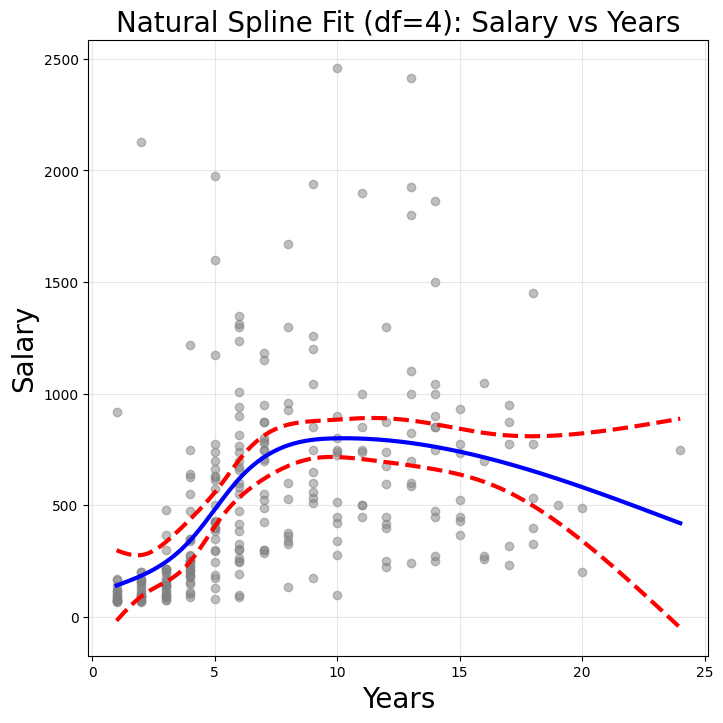

In [31]:
def plot_fit(x, y, basis, data, title): #function to plot the fit of the model
    # Create a smooth grid for plotting the fitted curve
    x_grid = pd.DataFrame({x.name: np.linspace(x.min(), x.max(), 300)})
    
    # Transform the original data and grid using the basis functions
    X = basis.transform(data) #transform the original data using the basis functions
    X_grid = basis.transform(x_grid) #transform the grid using the same basis functions
    
    # Fit the model
    M = sm.OLS(y, X).fit() #fit the model
    preds = M.get_prediction(X_grid) #get predictions for the grid
    bands = preds.conf_int(alpha=0.05) #get 95% confidence intervals for the predictions
    
    # Create the plot
    fig, ax = subplots(figsize=(8,8)) #create a figure and axis for plotting
    ax.scatter(x, y, facecolor='gray', alpha=0.5) #scatter plot of original data
    
    # Plot the fitted curve and confidence bands
    x_plot = x_grid[x.name].values
    for val, ls in zip([preds.predicted_mean, bands[:,0], bands[:,1]], 
                       ['b-', 'r--', 'r--']): 
        ax.plot(x_plot, val, ls, linewidth=3) #plot the predicted mean and confidence bands 
    
    ax.set_title(title, fontsize=20) 
    ax.set_xlabel(x.name, fontsize=20)
    ax.set_ylabel(y.name, fontsize=20)
    ax.grid(True, alpha=0.3)
    return ax

# Create the plot
plot_fit(Years, Salary, ns_years, Hitters, 'Natural Spline Fit (df=4): Salary vs Years')

Question 4

In [33]:
# load the College dataset
College = load_data('College').dropna()
Outstate = College['Outstate']
X_College = College[['Room.Board', 'PhD']]

In [38]:
gam = LinearGAM(s_gam(0)+s_gam(1))
gam_model = gam.fit(X_College,Outstate)
# Score the model on the training data
score = gam_model.score(X_College, Outstate)
print(f"GAM Score (Explained Deviance): {score:.4f}")

GAM Score (Explained Deviance): 0.5142


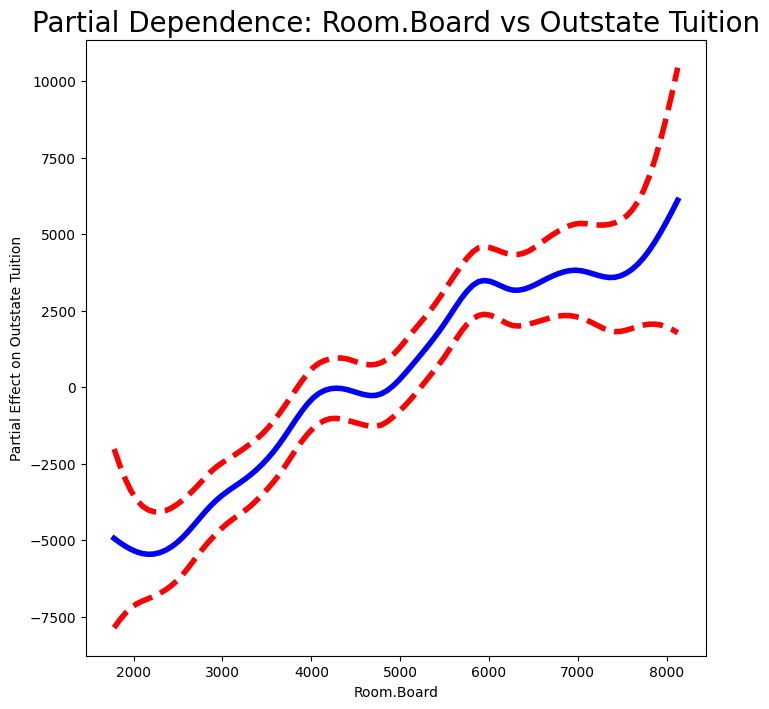

In [44]:
fig, ax = subplots(figsize=(8,8)) 
plot_gam(gam_model, 0, ax=ax) #plot the partial dependence of Room.Board (first predictor, index 0) on Outstate tuition using the fitted GAM model
ax.set_xlabel('Room.Board') 
ax.set_ylabel('Partial Effect on Outstate Tuition')
ax.set_title('Partial Dependence: Room.Board vs Outstate Tuition', fontsize=20);


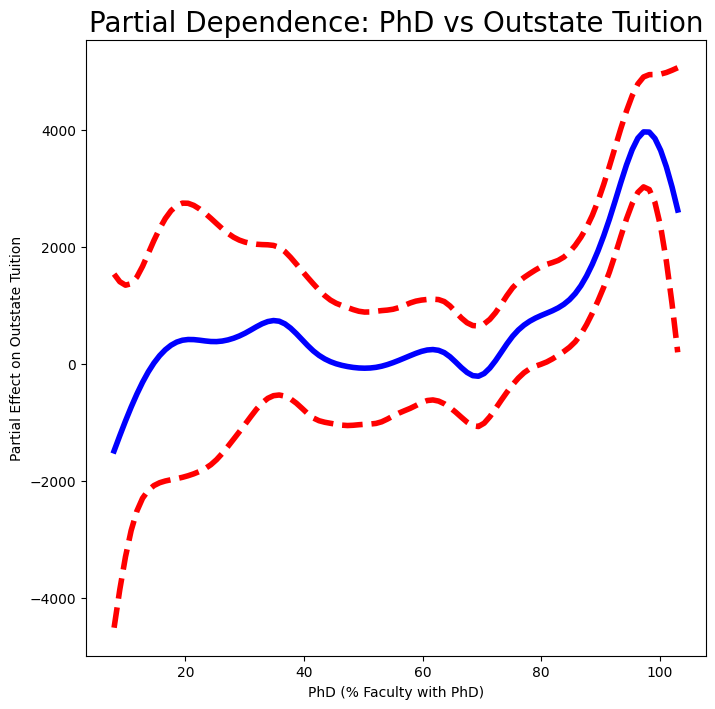

In [45]:
# Plot partial dependence for the second feature (PhD)
fig, ax = subplots(figsize=(8,8)) 
plot_gam(gam_model, 1, ax=ax) #plot the partial dependence of PhD (second predictor, index 1) on Outstate tuition
ax.set_xlabel('PhD (% Faculty with PhD)') 
ax.set_ylabel('Partial Effect on Outstate Tuition')
ax.set_title('Partial Dependence: PhD vs Outstate Tuition', fontsize=20);

Question 5

In [47]:
# load Carseats dataset
Carseats = load_data('Carseats').dropna()
Sales = Carseats['Sales']
Price = Carseats['Price']

In [53]:
X_Carseats = pd.cut(Price, bins=4)
X_Carseats_dummies = pd.get_dummies(X_Carseats, drop_first=True)

# Fit the step function model
M_car = sm.OLS(Sales, X_Carseats_dummies).fit()
summarize(M_car)

,coef,std err,t,P>|t|
"(65.75, 107.5]",8.6587,0.254,34.126,0.0
"(107.5, 149.25]",6.9535,0.201,34.634,0.0
"(149.25, 191.0]",5.4556,0.529,10.317,0.0


In [60]:
# Detailed analysis of the step function regression results
print("Step Function Regression Analysis:")
print("=================================")
print()


bins_info = pd.cut(Price, bins=4).cat.categories


# Get R-squared
print(f"R-squared: {M_car.rsquared:.6f}")
print(f"Adjusted R-squared: {M_car.rsquared_adj:.6f}")
print()

# Analyze coefficients
print("Coefficient Estimates:")
print("=====================")
coefficients = M_car.params
print("Note: These are relative to the baseline (lowest price bin)")
print(f"Baseline bin (24.0, 65.75]: Not shown (reference category)")

for bin_name, coef in coefficients.items():
    print(f"{bin_name}: {coef:.4f}")
print()

# Calculate actual predicted sales for each bin
# The baseline bin prediction is the intercept (which we don't have since we dropped first category)
# We need to get the mean sales for the reference category
reference_bin_mask = pd.cut(Price, bins=4) == bins_info[0]
baseline_sales = Sales[reference_bin_mask].mean()

print("Predicted Sales by Price Bin:")
print("=============================")
print(f"Bin 1 {bins_info[0]}: {baseline_sales:.4f} (baseline)")

for i, (bin_name, coef) in enumerate(coefficients.items(), 2):
    predicted_sales = baseline_sales + coef
    print(f"Bin {i} {bin_name}: {predicted_sales:.4f} (baseline + {coef:.4f})")


Step Function Regression Analysis:

R-squared: 0.861550
Adjusted R-squared: 0.860504

Coefficient Estimates:
Note: These are relative to the baseline (lowest price bin)
Baseline bin (24.0, 65.75]: Not shown (reference category)
(65.75, 107.5]: 8.6587
(107.5, 149.25]: 6.9535
(149.25, 191.0]: 5.4556

Predicted Sales by Price Bin:
Bin 1 (23.833, 65.75]: 10.9600 (baseline)
Bin 2 (65.75, 107.5]: 19.6187 (baseline + 8.6587)
Bin 3 (107.5, 149.25]: 17.9135 (baseline + 6.9535)
Bin 4 (149.25, 191.0]: 16.4156 (baseline + 5.4556)


All coefficients are POSITIVE relative to the baseline, this means the strongest NEGATIVE effect on sales comes from the LOWEST price bin. Sales INCREASE as we move to higher price bins